In [179]:
#trustworthiness --> sklearn
# distance correlation correlation --> zelf chefffen
# knn-overlap - distance curve and integral
# poincarre


### knn_overlap -> find knn in true space random sample. Then embedding do the same for indices -> jaccard score
__author__ = "Bram van ES", "Huibert-Jan Joosse", "Chontira Chumsaeng"

from setup_cc import *
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hembedder.utils._cpython._metrics_cy as metrics_cy

from tqdm import tqdm
from hembedder.utils import quality_metrics as qm

from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

In [2]:
from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

def get_scores(embedded_info): 
    #Get performance metrics for each subsampled embedder
    evaluate_n_n_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, n_neighbours=15, metric='manhattan')
    evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan')

    evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
            'dcor_1': evaluate._return_distance_correlation,
            'neighbor_kept_50' : evaluate.neighbor_kept_ratio_eval,
            'neighbor_kept' : evaluate_n_n_default.neighbor_kept_ratio_eval,
            'dcor_2': evaluate_n_n_default._return_distance_correlation,
            'Trustworthiness': evaluate._return_trustworthiness,
            'LCMC_Q_matrix': evaluate._return_LCMC,
            'Trustworthiness_Q_matrix': evaluate._return_Qtrustworthiness,
            'Continuit_Q_matrix':  evaluate._return_Qcontinuity,
            'nMRRE_Q_matrix' : evaluate._return_nMRRE,
            'vMRRE_Q_matrix' : evaluate._return_vMRRE,
            'Qnx_crm_Q_matrix': evaluate._return_qnx_crm,
            'Rnx_crm_Q_matrix': evaluate._return_rnx_crm,
            'Qnx_auc_crm_Q_matrix': evaluate._return_rnx_auc_crm}
    embedded_info.update({'evaluators': evaluators})
    scores = metrics_scores_iter(**embedded_info)
    return scores

def get_embedded_data(X,parameter:dict, embedder,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    X = np.asarray(X, dtype=np.float32)
    embedded_data = []
    times = []
    for iter in range(num_iter):
        start = time.time()
        sub = numpy_sampling(X, subsampling)
        # Evaluate randomly selected hyperparameters
        CD_scaled = sub.copy()
    
        scaler = StandardScaler()
        CD_scaled = scaler.fit_transform(sub)
        # Create a dictionary for later reference in multi-thread
        indexes_metrics= subsampling_return_indexes(sub, 5000)
        emb_dict = {"original" : sub[indexes_metrics],
                    "embedded" : embedder(**parameter).fit_transform(CD_scaled).astype(np.float32)[indexes_metrics]}
        embedded_data.append(emb_dict)
        #times.append(time.time()-start)
    return embedded_data

def get_embedded_without_embedding(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = []
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"x" : X[sample_index],
                    "output" : X_embedded[sample_index],
                    "Q":compute_coranking_matrix(X[sample_index],\
                    X_embedded[sample_index], leave = False).astype(np.int32)}
        embedded_data.append(emb_dict)
        
    return embedded_data

def metrics_scores_iter(
    x: np.array,
    output: np.array,
    evaluators: dict,
    **args
):
    """Calculates scores for embedder using different metrics (evaluators).

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = {}
    for name, metric in evaluators.items():
        if("Q" in args.keys() and "Q_matrix" in name):
            results.update({name: metric(x, output,args["Q"])})
        else:
            results.update({name: metric(x, output)})
    return results


def get_embedded_without_embedding_queue(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = queue.Queue()
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        print(len(sample_index))
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"original" : X[sample_index],
                    "embedded" : X_embedded[sample_index]}
        embedded_data.put(emb_dict)
        
    return embedded_data

def numpy_sampling(X, subsampling):  
    n_data = len(X) 
    idx = np.arange(n_data) 
    np.random.shuffle(idx) 
    return X[idx[: subsampling],:] 

def subsampling_return_indexes(X, subsampling):
    rand = np.random.default_rng()
    n_data = len(X) 
    subsampling = min(n_data, subsampling) 
    return  rand.choice(np.arange(n_data), size=subsampling, replace=False)

In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import trimap
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
import pacmap
import phate


metric = "manhattan"

embedder_3 = umap.UMAP(n_components=3,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_6 = umap.UMAP(n_components=6,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_15 = umap.UMAP(n_components=15,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_30 = umap.UMAP(n_components=30,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_60 = umap.UMAP(n_components=60,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)




embedder_3_all = umap.UMAP(n_components=3,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_6_all = umap.UMAP(n_components=6,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_15_all = umap.UMAP(n_components=15,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_30_all = umap.UMAP(n_components=30,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_60_all = umap.UMAP(n_components=60,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)


In [180]:
cell_dyn_with_labels = pd.read_feather("data/cell_dyn_gender_Full_100_encoded.feather")

cell_dyn = cell_dyn_with_labels.loc[:, cols_c_b_combo]


In [181]:
sample_index = cell_dyn_with_labels.sample(50000).index
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
indexes_metrics= subsampling_return_indexes(sampled_cd, 10000)
age = np.array(cell_dyn_with_labels.age.loc[sample_index])

In [168]:
org_data = pd.read_sas("T:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/celldyn.sas7bdat")


In [169]:
cell_dyn_with_labels['studyid_alle_celldyn'] = cell_dyn_with_labels.studyid_alle_celldyn.astype('Int64').astype(str)
# org_data['studyId_Alle_celldyn'] = org_data.studyId_Alle_celldyn.astype('Int64').astype(str)

In [170]:
org_data.columns = [c.lower() for c in org_data.columns]


In [171]:
missing_cols =[c for c in org_data if ('c_b_' in c) and (c.lower() not in cell_dyn_with_labels)]

In [172]:
org_data['asp_dt'] = org_data.asp_dt.astype('datetime64[ns, Europe/Berlin]')

C:\Users\hjoosse3\AppData\Local\Temp\ipykernel_15248\2262876763.py:1: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  org_data['asp_dt'] = org_data.asp_dt.astype('datetime64[ns, Europe/Berlin]')


In [173]:
cell_dyn_with_labels[missing_cols] = org_data.loc[cell_dyn_with_labels['index'],missing_cols]

In [174]:
cell_dyn[missing_cols] = org_data.loc[cell_dyn_with_labels['index'],missing_cols]

In [175]:
sample_index_all = cell_dyn.dropna().reset_index(drop = True).sample(50000).index
sampled_cd_all = np.asarray(cell_dyn.dropna().reset_index().loc[sample_index_all], dtype=np.float32)
# indexes_metrics= subsampling_return_indexes(sampled_cd, 10000)
# age = np.array(cell_dyn_with_labels.age.loc[sample_index])

### UMAP without all features (70 + 28 ratio's)

In [182]:
from scipy.signal import resample
performance_dict_umap = {}
for model in tqdm([embedder_3, embedder_6, embedder_15,embedder_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_umap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [57:30<00:00, 862.69s/it]


### UMAP WITH all features (79 + 28 ratio's)

In [183]:
from scipy.signal import resample
performance_dict_umap_all_features = {}
for model in tqdm([embedder_3, embedder_6, embedder_15,embedder_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd_all)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    
    eval_sample = sampled_cd_all[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_umap_all_features.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


  0%|          | 0/4 [00:00<?, ?it/s]

### plot results

AttributeError: 'NoneType' object has no attribute 'keys'

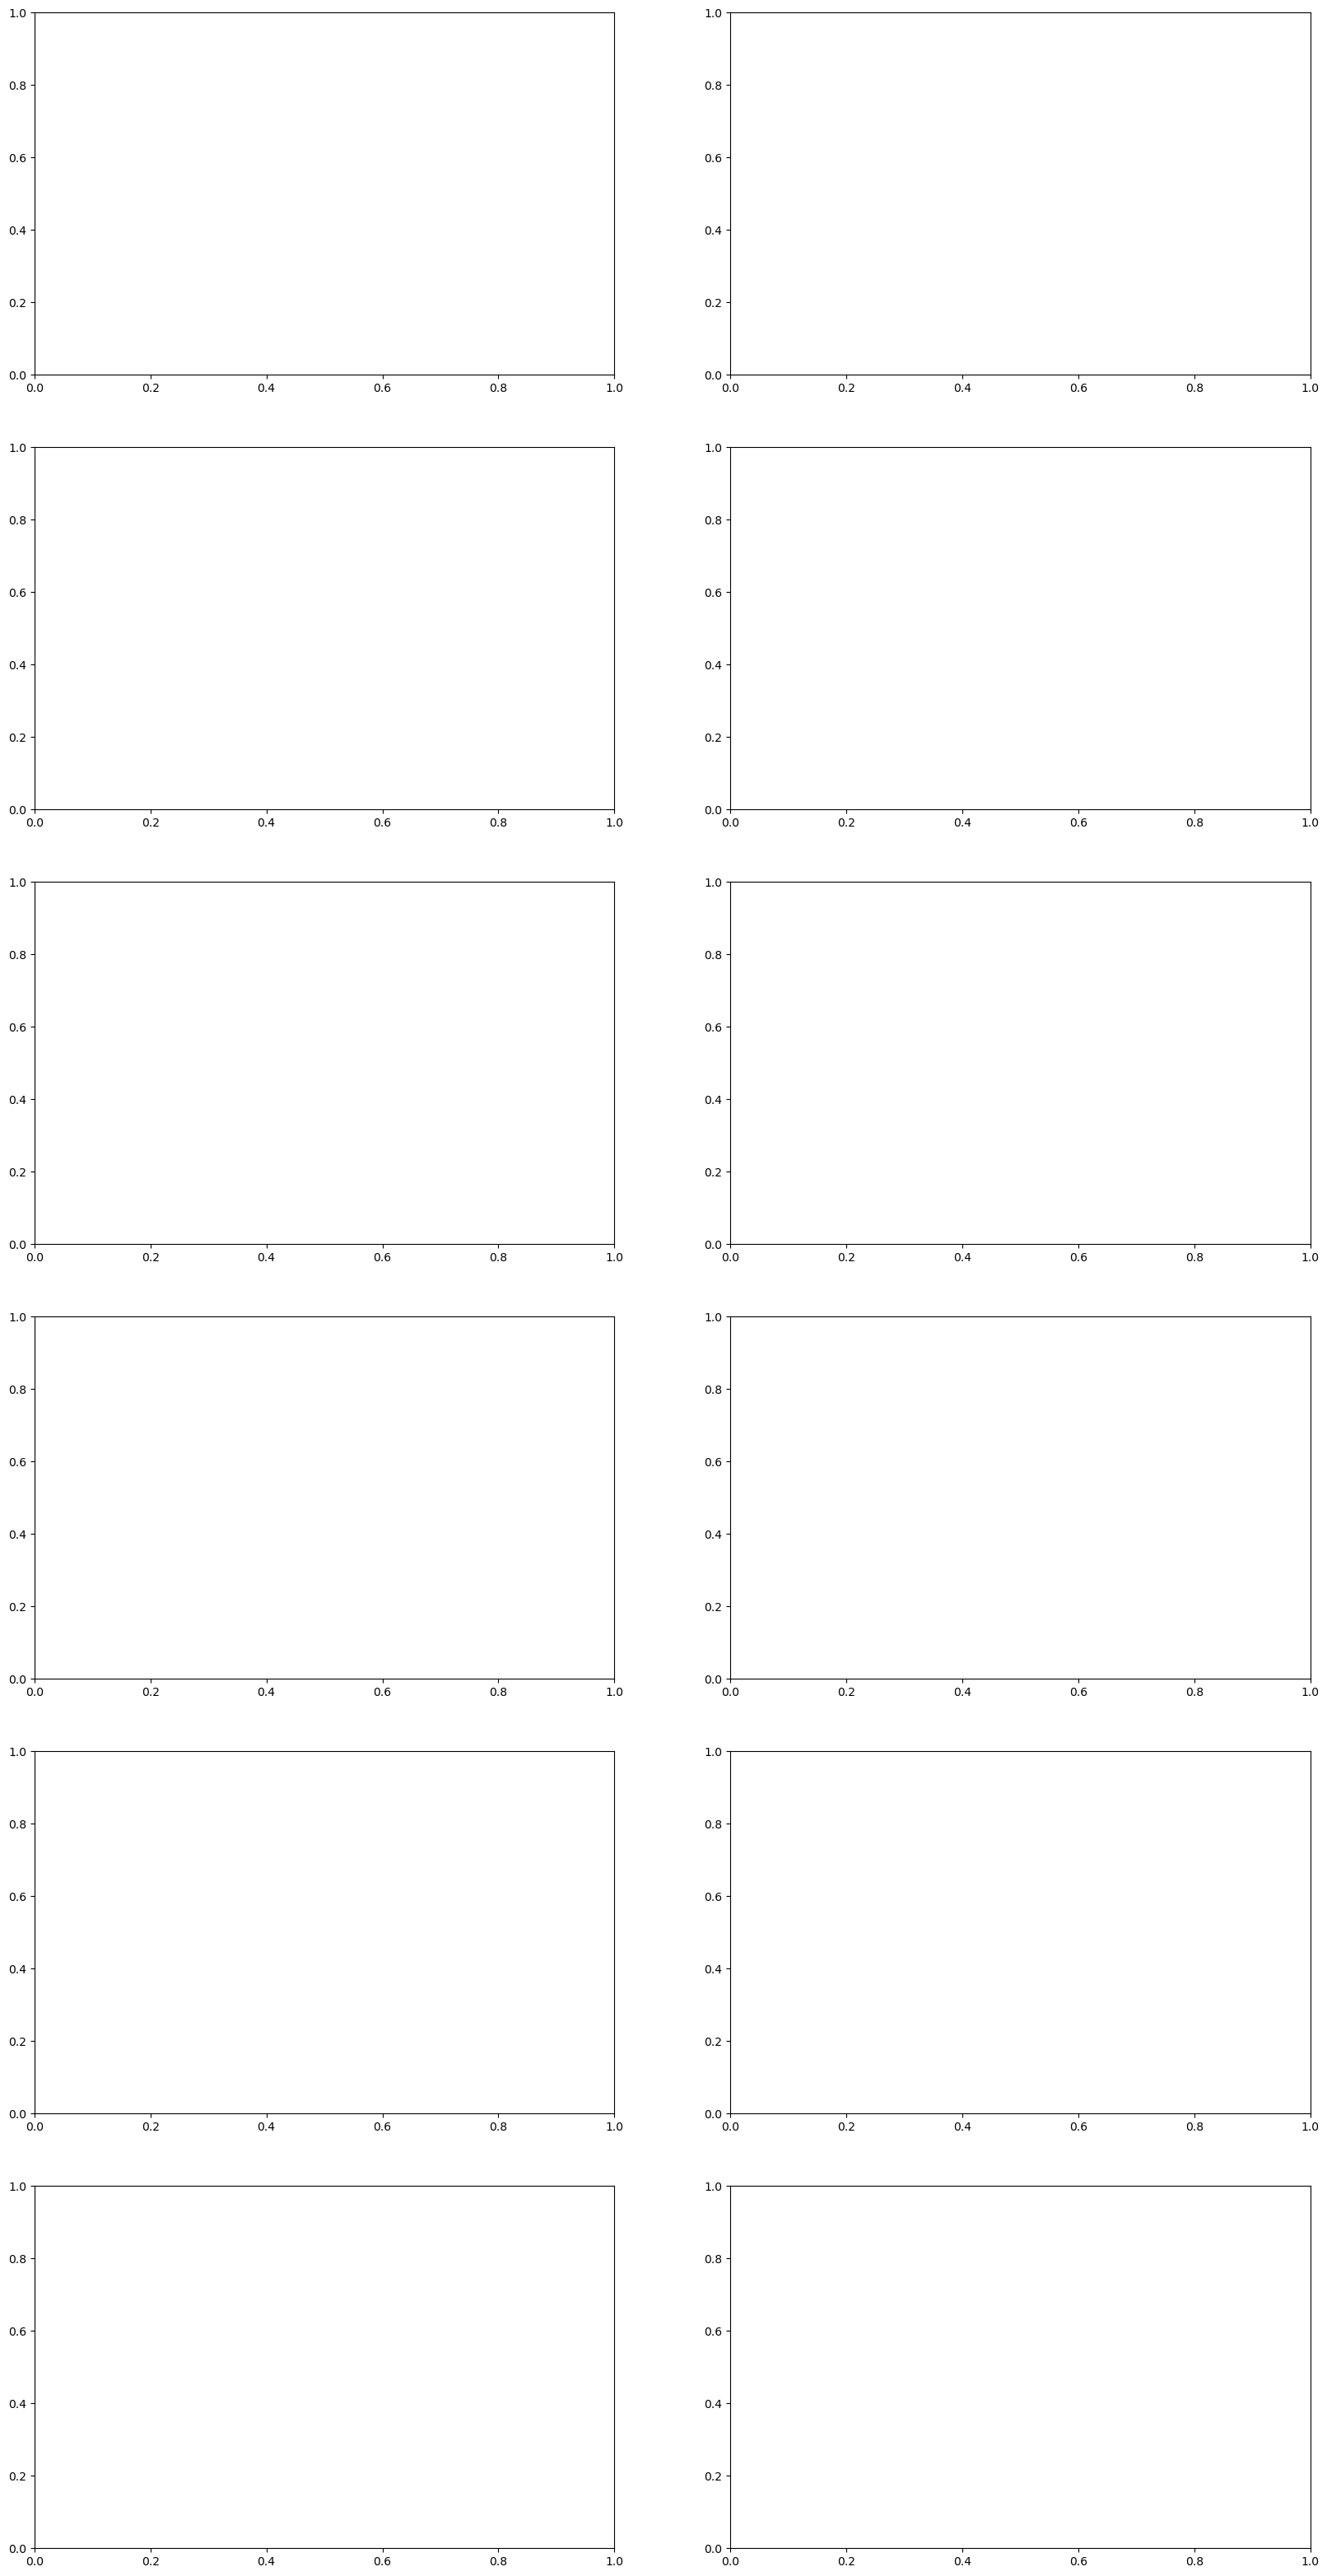

In [178]:
import re

fig, ax = plt.subplots(6,2,figsize = (20,40))

labels = ['not all features','all features']

for n,performances in enumerate([performance_dict_umap,performance_dict_umap_all_features]):
    perf_to_plot = None
    for key,value in performances.items():
        if perf_to_plot == None:
            perf_to_plot = {k[0]:[] for k in value}
            perf_to_plot.update({'n_dims':[]})
        for metric,score in value:
            perf_to_plot[metric].append(score)
        perf_to_plot['n_dims'].append(re.search(r"\d+",key).group())
        
    i,j = 0,0

    for metric in perf_to_plot.keys():
        if metric != "n_dims":
            ax[j,i].plot(perf_to_plot['n_dims'],perf_to_plot[metric], label = labels[n])
            ax[j,i].legend()
            ax[j,i].set_title(metric)
            j = j+1 if i == 1 else j
            i = 0 if i == 1 else 1
            
            